In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima_model import ARMA
from itertools import product
from datetime import datetime

In [4]:
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('./bitcoin_20120101_to_20181031.csv')
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,,
2011-12-31,2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119578,5.208159


#### visualize the average price

In [8]:
df_month = df.resample('M').mean()
df_quarter = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

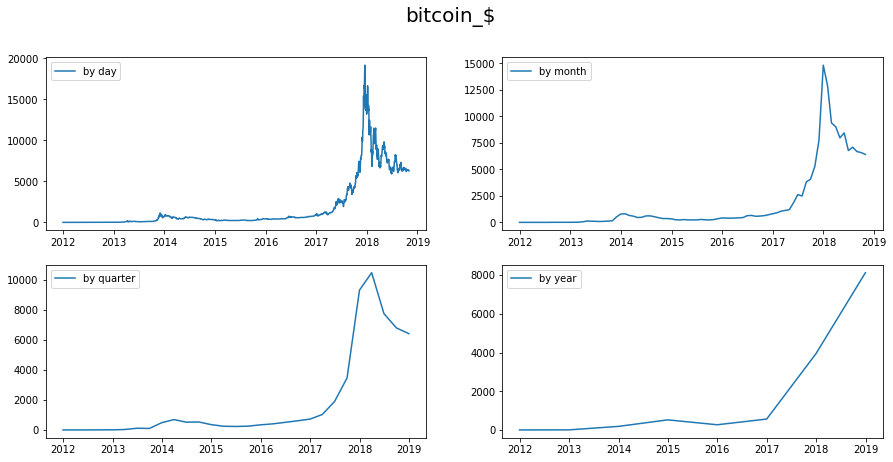

In [11]:
fig = plt.figure(figsize = [15,7])
plt.suptitle('bitcoin_$',fontsize=20)
plt.subplot(221)
plt.plot(df.Weighted_Price,'-',label='by day')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price,'-',label='by month')
plt.legend()
plt.subplot(223)
plt.plot(df_quarter.Weighted_Price,'-',label='by quarter')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price,'-',label='by year')
plt.legend()
plt.show()

#### train arma model

In [15]:
# set p and q
ps = range(0,4)
qs = range(0,4)
parameters = product(ps,qs)
parameters_list = list(parameters)

In [17]:
results =[]
best_aic = float('inf')
for param in parameters_list:
    try:
        model = ARMA(df_month.Weighted_Price,order=(param[0],param[1])).fit()
    except ValueError:
        print('ValueError',param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_aic = aic
        best_param = param
        best_model = model
    results.append([param,model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters','aic']
print('the best model:',best_model.summary())

ValueError (0, 2)
ValueError (0, 3)
the best model:                               ARMA Model Results                              
Dep. Variable:         Weighted_Price   No. Observations:                   83
Model:                     ARMA(1, 1)   Log Likelihood                -688.761
Method:                       css-mle   S.D. of innovations            957.762
Date:                Sun, 10 Oct 2021   AIC                           1385.523
Time:                        15:44:23   BIC                           1395.198
Sample:                    12-31-2011   HQIC                          1389.410
                         - 10-31-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2124.1210   1570.209      1.353      0.180    -953.432    5201.674
ar.L1.Weighted_Price     0.9252      0.042     22

#### bitcoin predict

In [22]:
df_month2 = df_month[['Weighted_Price']]
date_list=[datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31), datetime(2019, 2, 28), datetime(2019, 3, 31), datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30)]

In [26]:
future = pd.DataFrame(index=date_list,columns=df_month.columns)
df_month2 = pd.concat([df_month2,future])
df_month2['forecast']=best_model.predict(start=0,end=91)

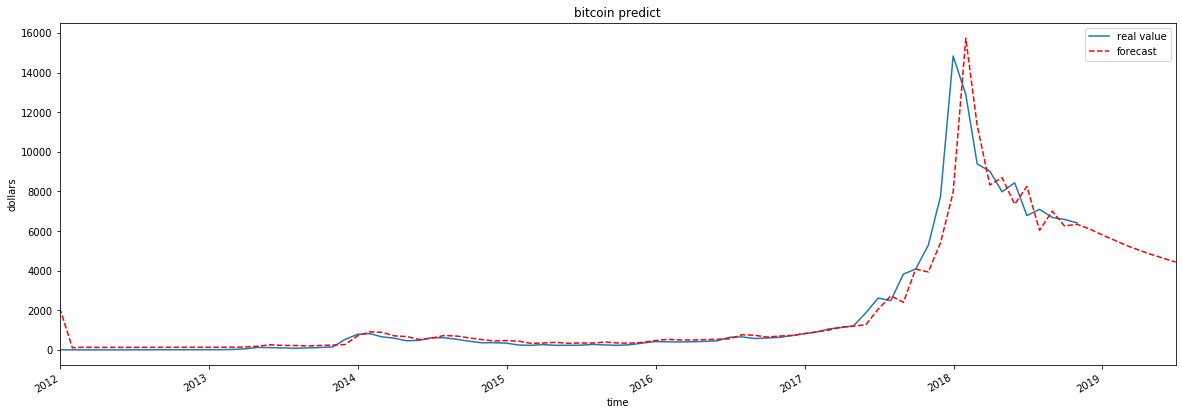

In [27]:
plt.figure(figsize=(20,7))
df_month2.Weighted_Price.plot(label='real value')
df_month2.forecast.plot(color='r',ls='--',label='forecast')
plt.legend()
plt.title('bitcoin predict')
plt.xlabel('time')
plt.ylabel('dollars')
plt.show()